In [1]:
# Xarray wip

In [2]:
import datetime
import numpy
import xarray
import rasterio
from lilcubeLib.lc_api import Lilcube
from noteLib import ge_translate

In [3]:
from lilcubeLib.lc_xarray import AOI_bounding_box, Xpart

In [4]:
aoi = AOI_bounding_box((30.209661,-2.218817,30.246396,-2.163926))

(30.209661, -2.218817, 30.246396, -2.163926)
Geometry({'type': 'Polygon', 'coordinates': [[(30.209661, -2.163926), (30.246396, -2.163926), (30.246396, -2.218817), (30.209661, -2.218817), (30.209661, -2.163926)]]}, CRS('EPSG:4326'))
TONY from geopoly - align (0.0, 0.0)
TONY from geopoly - offx offy boundin_box 189600.0 -239430.0 BoundingBox(left=189601.87096438574, bottom=-245539.96811257626, right=193702.6361953243, top=-239458.06816014828)
TONY GeoBox self.extent Geometry({'type': 'Polygon', 'coordinates': [[(189600.0, -239430.0), (189600.0, -245550.0), (193710.0, -245550.0), (193710.0, -239430.0), (189600.0, -239430.0)]]}, CRS('epsg:32636'))
(204, 137)
{'left': 30.209661, 'top': -2.163926, 'right': 30.246396, 'bottom': -2.218817}
GeoBox(Geometry({'type': 'Polygon', 'coordinates': [[(30.20964478189393, -2.163604772018508), (30.209542332161735, -2.2189074269759694), (30.246461853015774, -2.2189770533884112), (30.24656295147759, -2.163672661501062), (30.20964478189393, -2.16360477201850

In [5]:
date_range = (datetime.datetime(2013,7,6), datetime.datetime(2013,7,7))
# date_range = (datetime(2013,7,6), datetime(2018,7,7))

es_index = 'datacube'
es_type = 'rwanda'

lc = Lilcube()

#measurements = ('blue',)
#display_color='blue'

measurements = ('green',)
display_color='green'


# return a pandas data frame product id creation date and red
panda_df = lc.search(es_index, es_type, (aoi.ul_lat, aoi.ul_lon), (aoi.lr_lat, aoi.lr_lon),
             time = date_range, measurements = measurements )

creating Lilcube class
(datetime.datetime(2013, 7, 6, 0, 0), datetime.datetime(2013, 7, 7, 0, 0))
2013-07-06
Yay Connect
HIT COUNT = 2
##########################################################################################
LC08_L1TP band4 172 61 2013-07-06 /mnt/rwanda/LC08/172/061/2013/LC081720612013070601T1-SC20181130015946/LC08_L1TP_172061_20130706_20170503_01_T1_sr_band4.tif /mnt/rwanda/LC08/172/061/2013/LC081720612013070601T1-SC20181130015946/LC08_L1TP_172061_20130706_20170503_01_T1_sr_band3.tif /mnt/rwanda/LC08/172/061/2013/LC081720612013070601T1-SC20181130015946/LC08_L1TP_172061_20130706_20170503_01_T1_sr_band2.tif
LC08_L1TP band4 172 62 2013-07-06 /mnt/rwanda/LC08/172/062/2013/LC081720622013070601T1-SC20181129211703/LC08_L1TP_172062_20130706_20170503_01_T1_sr_band4.tif /mnt/rwanda/LC08/172/062/2013/LC081720622013070601T1-SC20181129211703/LC08_L1TP_172062_20130706_20170503_01_T1_sr_band3.tif /mnt/rwanda/LC08/172/062/2013/LC081720622013070601T1-SC20181129211703/LC08_L1TP_172062

In [6]:
#redfile = panda_df['red'][0]
#xpart = Xpart(aoi.geobox,redfile)

In [7]:
def return_aoi_window(ul,lr, file):
    with rasterio.open(file) as src:
        ep = 'epsg:32636'
        ulx,uly = ge_translate(ul[0],ul[1],epsg=ep)
        row1,col1 = src.index(ulx,uly)
        lrx,lry = ge_translate(lr[0],lr[1],epsg=ep)

        row2,col2 = src.index(lrx, lry)
        print(row1,col1)
        print(row2,col2)
        rows = (row1,row2)
        cols = (col1,col2)
        return rows, cols

In [8]:
def read_data_from_geotiff(databuf, index, color, geobox, df):
    geoTiff = df.iloc[index][color]
    print(geoTiff)
    # Note that the blocksize of the image is 256 by 256, so we want xarray to use some multiple of that
    xchunk = 2048
    ychunk = 2048
    da = xarray.open_rasterio(geoTiff, chunks={'band': 1, 'x': xchunk, 'y': ychunk})
    # print(geobox)
    # print(dir(geobox))
    gextent = geobox.geographic_extent
    # print(dir(gextent))
    bb = gextent.boundingbox
    # print(bb)
    ul = (bb.top, bb.left)
    lr = (bb.bottom, bb.right)
    ep = 'epsg:32636'
    
    
    with rasterio.open(geoTiff) as src:
        print(src.crs)
        ulx,uly = ge_translate(ul[0],ul[1],epsg=ep)
        row1,col1 = src.index(ulx,uly)
        lrx,lry = ge_translate(lr[0],lr[1],epsg=ep)

        row2,col2 = src.index(lrx, lry)
        #print(row1,col1)
        #print(row2,col2)
        rows = (row1,row2)
        cols = (col1,col2)
        print(rows, cols)
    
    print(da)
    my_raster = da.sel(band=1)
   
    print(my_raster.shape)
    print(rows[0], rows[1])
    holding_tank = my_raster[rows[0]:rows[1], cols[0]:cols[1]]
    numpy.copyto(databuf,holding_tank)
    


In [9]:
def build_the_xarray(geobox, measures, df):
    THE_XARRAY = xarray.Dataset(attrs={'crs': geobox.crs})
    
    print(THE_XARRAY)
    time_coords = []
    for idx, val in df.iterrows():
        key = val['date'] + '_' + val['path'] + '_' + val['row']
        print (key)
        time_coords.append(key)
    
    THE_XARRAY['datePR'] = time_coords
    print(THE_XARRAY)
    
    #print(geobox.coordinates.items())
    
    for name, coord in geobox.coordinates.items():
            THE_XARRAY[name] = (name, coord.values, {'units': coord.units})
            print("GN=",name)
            print(name, len(coord.values))
            print(name, coord.values[0])
    print(THE_XARRAY)
    
    datePR_shape = (len(time_coords), )
    
    for color in measures:
        data = numpy.full(datePR_shape + geobox.shape, '-9999', dtype='int16')

        print("data.shape", data.shape)
    
        attrs = {
                    'nodata': '-9999',
                    'units': 'metres',
                    'crs': geobox.crs
                }

    #dims = 'datePR' + tuple(geobox.dimensions)
    
        dims = ('datePR', 'y', 'x')
    
        THE_XARRAY[color] = (dims, data, attrs)
        # we NOW have an EMPTY XARRAY
        print(THE_XARRAY)
    
        for index in range(0,len(time_coords)):
            read_data_from_geotiff(data[index], index, color, geobox, df)
    
        print(THE_XARRAY)
        
        
    return THE_XARRAY

    

In [10]:
ds = build_the_xarray(aoi.geobox, measurements, panda_df)



<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    crs:      epsg:32636
2013-07-06_172_61
2013-07-06_172_62
<xarray.Dataset>
Dimensions:  (datePR: 2)
Coordinates:
  * datePR   (datePR) <U17 '2013-07-06_172_61' '2013-07-06_172_62'
Data variables:
    *empty*
Attributes:
    crs:      epsg:32636
Tony geobox self.crs.dimensions, self.crs.units ('y', 'x') ('metre', 'metre')
GN= y
y 204
y -239445.0
GN= x
x 137
x 189615.0
<xarray.Dataset>
Dimensions:  (datePR: 2, x: 137, y: 204)
Coordinates:
  * datePR   (datePR) <U17 '2013-07-06_172_61' '2013-07-06_172_62'
  * y        (y) float64 -2.394e+05 -2.395e+05 ... -2.455e+05 -2.455e+05
  * x        (x) float64 1.896e+05 1.896e+05 1.897e+05 ... 1.937e+05 1.937e+05
Data variables:
    *empty*
Attributes:
    crs:      epsg:32636
data.shape (2, 204, 137)
<xarray.Dataset>
Dimensions:  (datePR: 2, x: 137, y: 204)
Coordinates:
  * datePR   (datePR) <U17 '2013-07-06_172_61' '2013-07-06_172_62'
  * y        (y) float64 -2.394e+05 

In [11]:
ds
ds2 = ds.sel(datePR=slice('2013-07-06_172_61', '2013-07-06_172_62'))

#ds.sel(datePR=slice('2013-07-06_172_61', '2013-07-06_172_62')).plot.imshow('x', 'y', col='time', col_wrap=4)

In [12]:
ds2

<xarray.Dataset>
Dimensions:  (datePR: 2, x: 137, y: 204)
Coordinates:
  * datePR   (datePR) <U17 '2013-07-06_172_61' '2013-07-06_172_62'
  * y        (y) float64 -2.394e+05 -2.395e+05 ... -2.455e+05 -2.455e+05
  * x        (x) float64 1.896e+05 1.896e+05 1.897e+05 ... 1.937e+05 1.937e+05
Data variables:
    green    (datePR, y, x) int16 682 835 827 808 787 ... 501 494 498 491 494
Attributes:
    crs:      epsg:32636

In [13]:
dir(ds2)

['_Dataset__default_attrs',
 '_HANDLED_TYPES',
 '__abs__',
 '__abstractmethods__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__dask_graph__',
 '__dask_keys__',
 '__dask_optimize__',
 '__dask_postcompute__',
 '__dask_postpersist__',
 '__dask_scheduler__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__

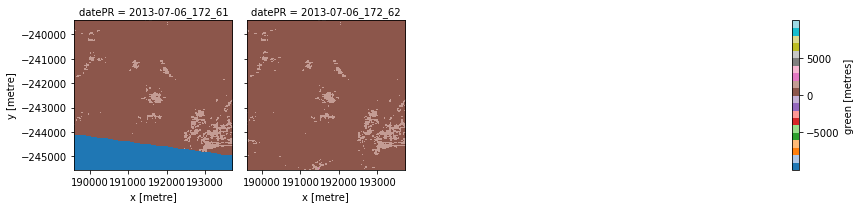

In [14]:
ds2[display_color].plot.imshow('x', 'y', col='datePR', col_wrap=4, cmap='tab20')

https://matplotlib.org/examples/color/colormaps_reference.html

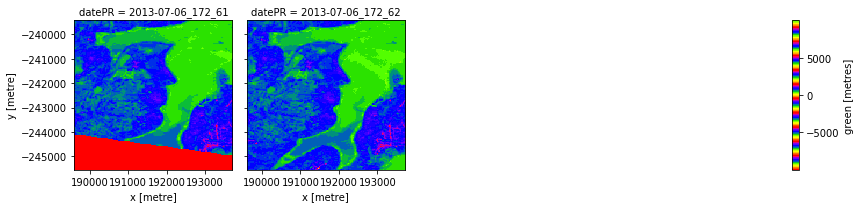

In [15]:
ds2[display_color].plot.imshow('x', 'y', col='datePR', col_wrap=4, cmap='prism')

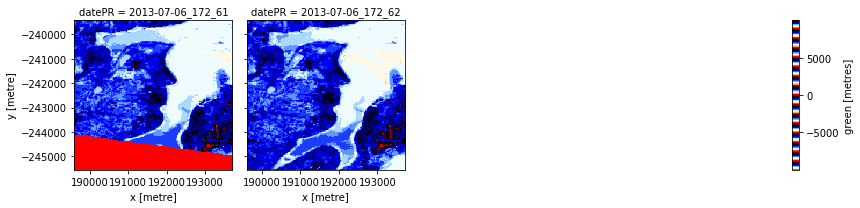

In [16]:
ds2[display_color].plot.imshow('x', 'y', col='datePR', col_wrap=4, cmap='flag')

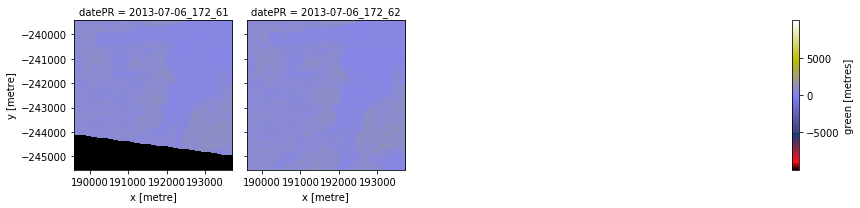

In [17]:
ds2[display_color].plot.imshow('x', 'y', col='datePR', col_wrap=4, cmap='gist_stern')

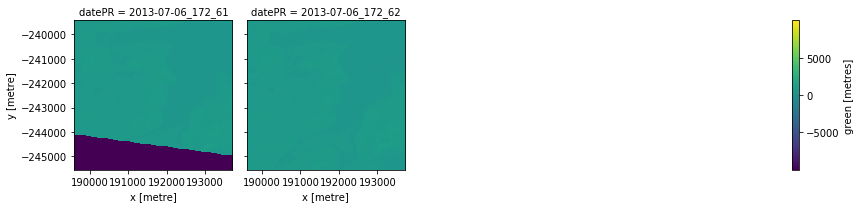

In [18]:
ds2[display_color].plot.imshow('x', 'y', col='datePR', col_wrap=4, cmap='viridis')

In [19]:
!date

Thu Jan 17 08:27:27 CST 2019
